<a href="https://colab.research.google.com/github/Suchith19792/MachineLearning-Samples/blob/master/Anomaly_detection_on_Simpsons_and_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1/D
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!**

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it.

**Deadlines and grades:**
  * 2020.09.20 - 2020.10.20 ==> 5
  * 2020.10.21 - 2020.10.27 ==> 4
  * 2020.10.28 - 2020.11.03 ==> 3
  * 2020.11.04 - 2020.11.10 ==> 2
  * 2020.11.11 or later ==> 1

You can **use only these** 3rd party **packages:** `cv2, keras, matplotlib, numpy, sklearn, skimage, tensorflow`.

### Description
In this assignment you have to build a reconstruction loss based anomaly detection model using tf.keras. You have to train an autoencoder to reconstruct Homer Simpson images, then use the trained model to classify Simpson and Flower images. To implement such kind of models, you should take a look at the following classes and methods: `Sequential model, Funcitonal API, MaxPooling2D, Conv2DTranspose`.


## Prepare dataset

### Simpsons
* Download the Simpsons Characters dataset. Here you can find more information about the dataset: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset
* After extracting it, select only those images, on which Homer Simpson is present.
* Resize all image to be 64x64.
* Then split the datasets into train-val-test sets (ratio: 60-20-20), without shuffling.
* Print the size of each set and plot 5 training images and their corresponding masks.
* Normalize the datasets. All value should be between -1.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

### Flowers
* Download the Flowes Recognition dataset. Here you can find more information about the dataset: https://www.kaggle.com/alxmamaev/flowers-recognition
* After extracting it, resize all image to be 64x64.
* Print the size of each set and plot 5 training images and their corresponding masks.
* And finally normalize the datasets. All value should be between -1.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

In [ ]:
# Simpsons characters
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1odJvgHZXoShkWN5s3FNE1nDW_7wzxS3J" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1odJvgHZXoShkWN5s3FNE1nDW_7wzxS3J" -o simpsons_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2487      0 --:--:-- --:--:-- --:--:--  2472
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1104M    0 1104M    0     0  76.0M      0 --:--:--  0:00:14 --:--:-- 73.9M


In [ ]:
!unzip simpsons_dataset.zip

In [ ]:
# Flowers Recgonition
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1X1BDlF-Zuu7TIL9K4f7qOn7KGbS2_csw" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1X1BDlF-Zuu7TIL9K4f7qOn7KGbS2_csw" -o flowers-recognition.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3813      0 --:--:-- --:--:-- --:--:--  3813
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  224M    0  224M    0     0  49.3M      0 --:--:--  0:00:04 --:--:-- 59.7M


In [ ]:
!unzip flowers-recognition.zip

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
import os
from PIL import Image

In [ ]:
#homer data directory
homer_dir = os.path.join('/content/simpsons_dataset/homer_simpson')

#flower data directory
flower_dir = os.path.join('/content/flowers')

In [ ]:
homer_pic_names = os.listdir(homer_dir)
flower_pic_names = []
for flower in os.listdir(flower_dir):
  cur_fdir = os.path.join(flower_dir,flower)
  flower_pic_names.extend(os.listdir(cur_fdir))
print(len(homer_pic_names),homer_pic_names[:10])
print(sum([len(files) for r,d,files in os.walk(flower_dir)]), os.listdir(flower_dir))
print(len(flower_pic_names), flower_pic_names[:10])

2246 ['pic_1507.jpg', 'pic_0667.jpg', 'pic_0254.jpg', 'pic_1613.jpg', 'pic_0702.jpg', 'pic_0967.jpg', 'pic_1551.jpg', 'pic_1951.jpg', 'pic_1338.jpg', 'pic_0847.jpg']
4326 ['daisy', 'tulip', 'sunflower', 'dandelion', 'rose']
4326 ['102841525_bd6628ae3c.jpg', '4065883015_4bb6010cb7_n.jpg', '5883162120_dc7274af76_n.jpg', '19975899671_ebc42b7865_n.jpg', '11023272144_fce94401f2_m.jpg', '18635898912_eb8e058ef0.jpg', '7320089276_87b544e341.jpg', '5014137563_d03eb0ed75_n.jpg', '705422469_ffa28c566d.jpg', '5602738326_97121e007d_n.jpg']


In [ ]:
for f in os.listdir(flower_dir):
  ftypes = set()
  for pic in os.listdir(os.path.join(flower_dir,f)):
    ftypes.add(pic[pic.rfind('.'):])
  print(f, ftypes)

daisy {'.jpg'}
tulip {'.jpg'}
sunflower {'.jpg'}
dandelion {'.pyc', '.jpg', '.py'}
rose {'.jpg'}


In [ ]:
import shutil
from pathlib import Path

#Path(flower_dir+'/flowers').rmdir()
Path(flower_dir+'/flowers').mkdir(parents=True, exist_ok=True)
dest_dir = os.path.join(flower_dir,'flowers')
for flower in os.listdir(flower_dir):
  cur_fdir = os.path.join(flower_dir,flower)
  for file in os.listdir(cur_fdir):
    fpath = os.path.join(cur_fdir,file)
    try:
      shutil.copy2(fpath,dest_dir)
    except:
      pass


In [ ]:
#homer data directory
homer_dir = os.path.join('/content/simpsons_dataset/homer_simpson')
homer_pic_names = os.listdir(homer_dir)

#flower data directory
flower_dir = os.path.join('/content/flowers/flowers')
flower_pic_names = os.listdir(flower_dir)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

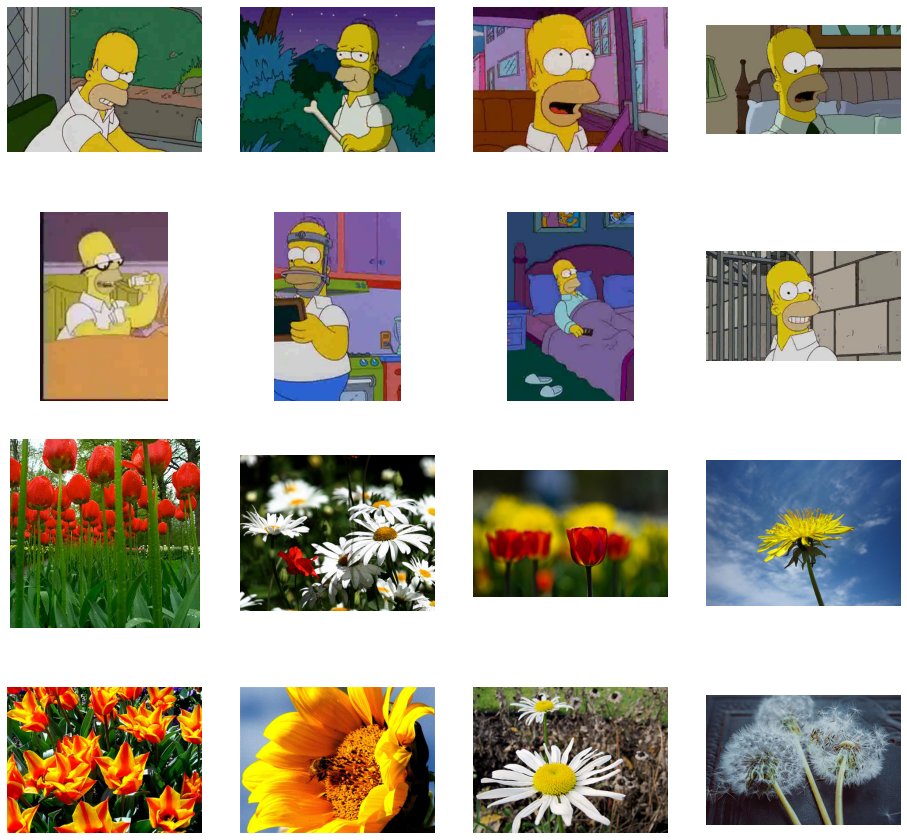

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_homer_pic = [os.path.join(homer_dir, fname)
                for fname in homer_pic_names[pic_index-8:pic_index]]
next_flower_pic = [os.path.join(flower_dir, fname)
                for fname in flower_pic_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_homer_pic+next_flower_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
npc = pd.read_csv('number_pic_char.csv')
npc.head()

,Unnamed: 0,name,total,train,test,bounding_box
0,0,Homer Simpson,2246,1909,337,612
1,1,Ned Flanders,1454,1236,218,595
2,2,Moe Szyslak,1452,1234,218,215
3,3,Lisa Simpson,1354,1151,203,562
4,4,Bart Simpson,1342,1141,201,554


In [ ]:
annot_df = pd.read_csv('annotation.txt',names=['path','bb_x1','bb_y1','bb_x2','bb_y2','character'])
homer_annot = annot_df[annot_df.character == 'homer_simpson']
homer_annot['pic_name'] = homer_annot['path'].apply(lambda x: x[x.rfind('/')+1:])
homer_annot.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bb_x1,bb_y1,bb_x2,bb_y2
count,612.000000,612.000000,612.000000,612.000000
mean,132.145425,41.555556,349.666667,352.156863
std,81.236154,40.872464,115.578839,67.314866
min,1.000000,0.000000,107.000000,8.000000
25%,68.000000,13.000000,252.000000,312.000000
50%,128.500000,29.000000,336.500000,355.000000
75%,191.000000,57.000000,448.000000,406.000000
max,471.000000,332.000000,631.000000,479.000000


In [ ]:
def draw_box(image, bb, color_palette='tab20', palette_samples=16):
    try:
        colors = np.round(
            np.array(plt.get_cmap(color_palette).colors) * 255
        ).astype(np.uint8)[:, ::-1].tolist()
    except AttributeError:  # if palette has not pre-defined colors
        colors = np.round(
            np.array(plt.get_cmap(color_palette)(np.linspace(0, 1, palette_samples))) * 255
        ).astype(np.uint8)[:, -2::-1].tolist()

    image = cv2.rectangle(image, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), color=(0,0,0), thickness=4)

    return image

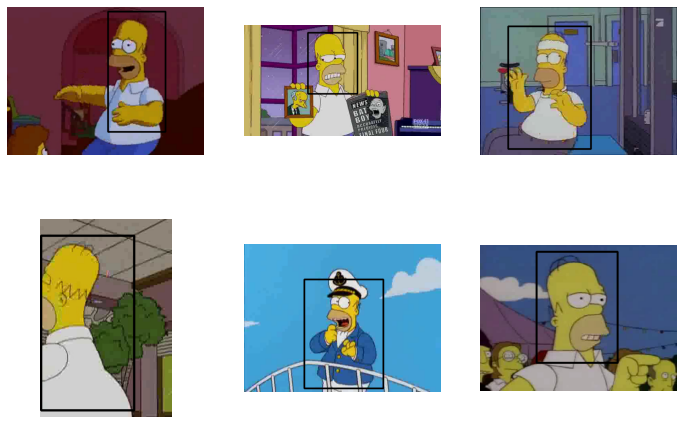

In [ ]:
ind = np.random.choice(len(homer_annot),6)
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 2
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

homer_pics = [list(homer_annot['pic_name'])[i] for i in ind]
next_flower_pic = [os.path.join(flower_dir, fname)
                for fname in flower_pic_names[pic_index-8:pic_index]]

for i,pic in enumerate(homer_pics):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img_path = os.path.join(homer_dir,pic)
  img = mpimg.imread(img_path)
  bb = np.array(homer_annot[homer_annot['pic_name'] == pic])[0][1:5]
  img = draw_box(img,bb)
  plt.imshow(img)

plt.show()

In [ ]:
homer_array = np.array([np.array(Image.open(os.path.join(homer_dir,img)).resize((64,64))) for img in os.listdir(homer_dir) if img[img.rfind('.'):]=='.jpg'])
flower_array = np.array([np.array(Image.open(os.path.join(flower_dir,img)).resize((64,64))) for img in os.listdir(flower_dir) if img[img.rfind('.'):]=='.jpg'])

In [ ]:
print(homer_array.shape, flower_array.shape)

(2246, 64, 64, 3) (4319, 64, 64, 3)


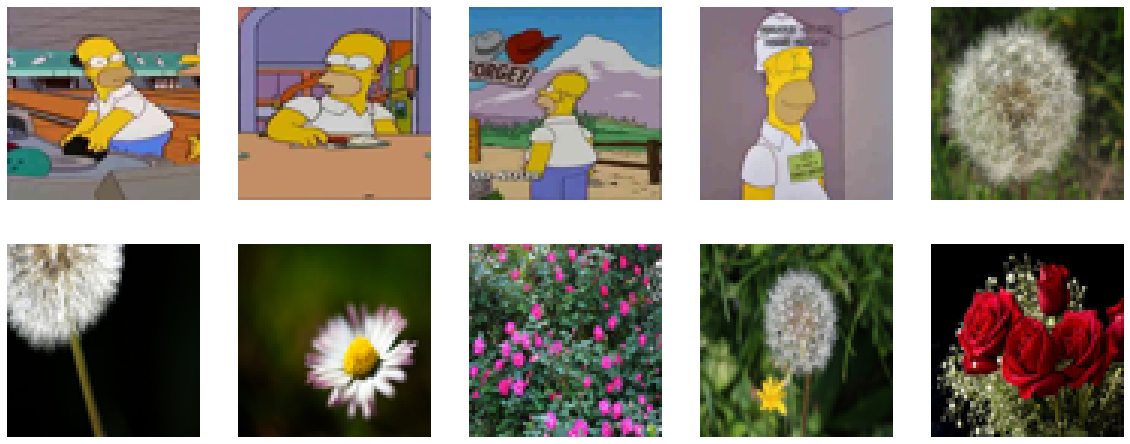

In [ ]:
homer_ind = list(np.random.choice(homer_array.shape[0],5))
flower_ind = list(np.random.choice(flower_array.shape[0],5))
#print(homer_ind+flower_ind)
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 2
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i,ind in enumerate(homer_ind+flower_ind):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  if i<4:
    plt.imshow(homer_array[ind])
  else:
    plt.imshow(flower_array[ind])

plt.show()

In [ ]:
homer_len = len(homer_array)
homer_train,homer_val,homer_test = np.split(homer_array,[int(0.6*homer_len), int(0.8*homer_len)])

flower_len = len(flower_array)
flower_train,flower_val,flower_test = np.split(flower_array,[int(0.6*flower_len), int(0.8*flower_len)])

print(homer_train.shape,homer_val.shape,homer_test.shape)
print(flower_train.shape,flower_val.shape,flower_test.shape)

#homer_train,homer_val,homer_test = homer_train/255.0,homer_val/255.0,homer_test/255.0
#flower_train,flower_val,flower_test = flower_train/255.0, flower_val/255.0, flower_test/255.0

#print(homer_train.shape,homer_val.shape,homer_test.shape)
#print(flower_train.shape,flower_val.shape,flower_test.shape)

(1347, 64, 64, 3) (449, 64, 64, 3) (450, 64, 64, 3)
(2591, 64, 64, 3) (864, 64, 64, 3) (864, 64, 64, 3)


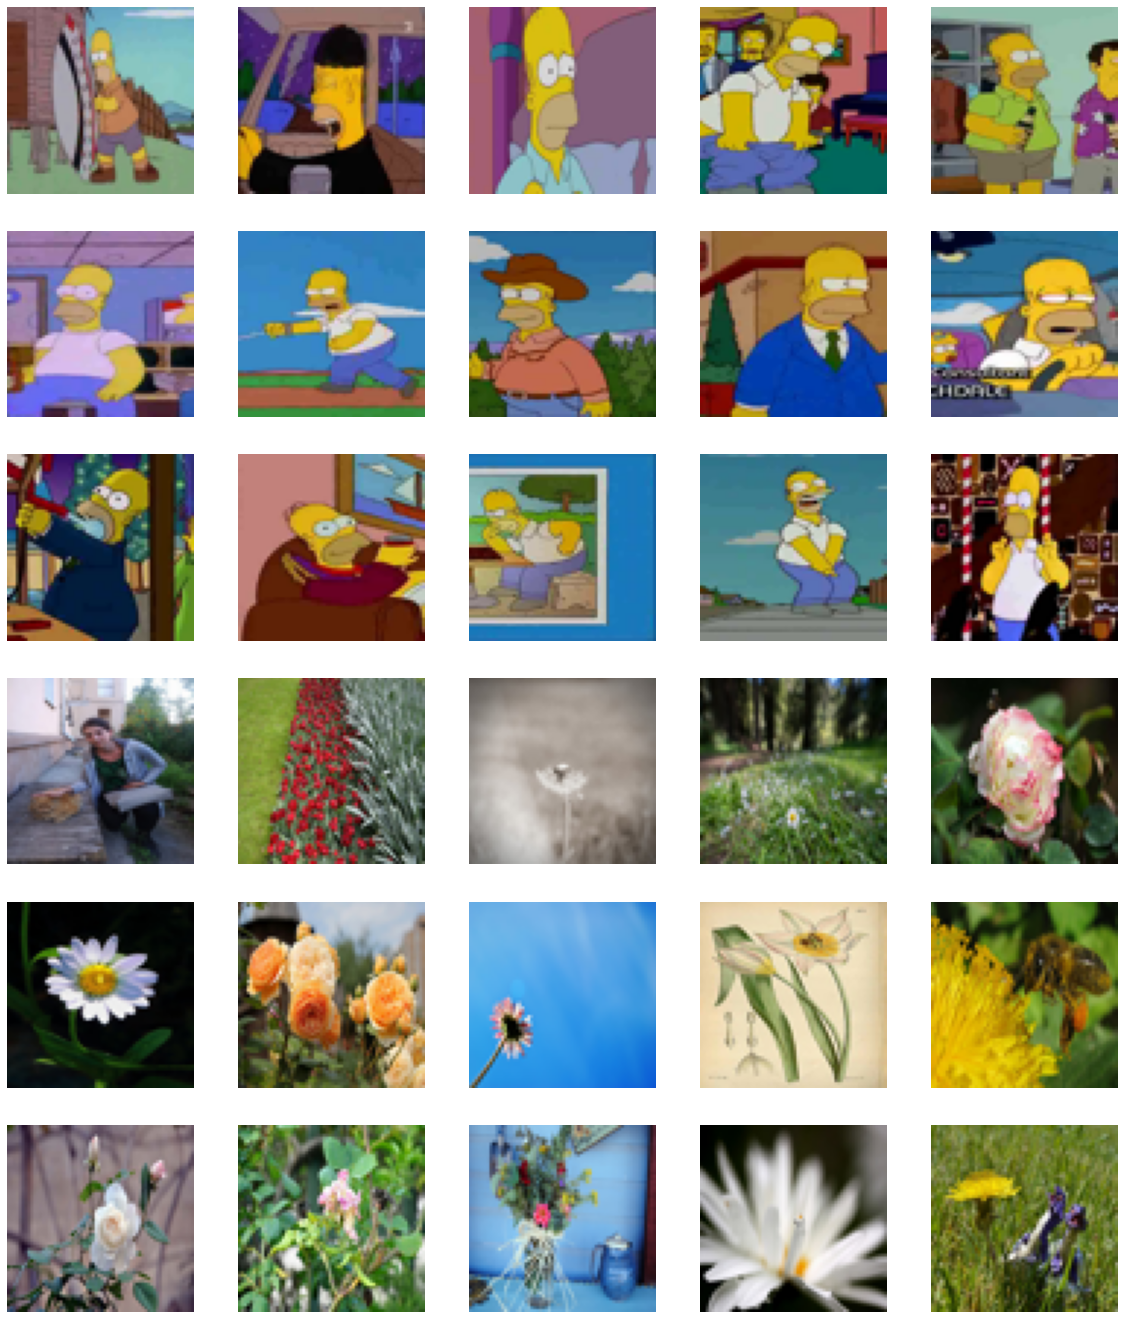

In [ ]:
homer_tr_ind = list(np.random.choice(homer_train.shape[0],5))
homer_val_ind = list(np.random.choice(homer_val.shape[0],5))
homer_test_ind = list(np.random.choice(homer_test.shape[0],5))
flower_tr_ind = list(np.random.choice(flower_train.shape[0],5))
flower_val_ind = list(np.random.choice(flower_val.shape[0],5))
flower_test_ind = list(np.random.choice(flower_test.shape[0],5))
#print(homer_ind+flower_ind)
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
indices = homer_tr_ind+homer_val_ind+homer_test_ind+flower_tr_ind+flower_val_ind+flower_test_ind
for i,ind in enumerate(indices):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  if i<5:
    plt.imshow(homer_train[ind])
  elif i<10:
    plt.imshow(homer_val[ind])
  elif i<15:
    plt.imshow(homer_test[ind])
  elif i<20:
    plt.imshow(flower_train[ind])
  elif i<25:
    plt.imshow(flower_val[ind])
  else:
    plt.imshow(flower_test[ind])

plt.show()

## Data augmentation
  * Augment the training set using `ImageDataGenerator`. The parameters should be the following: `featurewise_center=False, featurewise_std_normalization=False, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True`.
  * When creating the generator(s), use shuffling with a seed value of 0 and batch size of 128.
  * To validate that the augmentation is working, plot 5 original images with their corresponding transformed (augmented) images.

**Keep in mind:** Your task is to reconstuct images, so your target is your input. To augment the inputs and targets the same way, you should create 2 separate generator, then you can zip them together.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)
train_datagen.fit(homer_train)

test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(homer_val)

homer_tr_in = train_datagen.flow(homer_train,batch_size=128,shuffle=True,seed=0)
homer_tr_out = train_datagen.flow(homer_train,batch_size=128,shuffle=True,seed=0)
homer_tr_gen = zip(homer_tr_in,homer_tr_out)

homer_val_in = test_datagen.flow(homer_val,batch_size=128,shuffle=True,seed=0)
homer_val_out = test_datagen.flow(homer_val,batch_size=128,shuffle=True,seed=0)
homer_val_gen = zip(homer_val_in,homer_val_out)

In [ ]:
"""
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

# generate batch of images
for i in range(4):
  # convert to unsigned integers
  image = next(homer_tr_in)[0]
  print(type(image),image.shape)
  #print(image*255)

  # plot image
  ax[i].imshow(image)
  ax[i].axis('off')
"""

"\n# generate samples and plot\nfig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))\n\n# generate batch of images\nfor i in range(4):\n  # convert to unsigned integers\n  image = next(homer_tr_in)[0]\n  print(type(image),image.shape)\n  #print(image*255)\n\n  # plot image\n  ax[i].imshow(image)\n  ax[i].axis('off')\n"

## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 64)           0         
_________________________________________________________________
dense (Dense)                (None, 256, 1024)         66560     
_________________________________________________________________
dense_1 (Dense)              (None, 256, 256)          262400    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        147520    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 3)         867       
=================================================================
Total params: 653,731
Trainable params: 653,731
Non-trainable params: 0
_________________________________________________________________
```
* Use relu, a kernel size of 3x3 and `padding='same'` for each layer.
* Use a 3x3 `Conv2DTranspose` layer to upsample the result.
* For optimizer use Adam, and MAE as loss function, and add MSE as a metric.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [ ]:
def ae_model(input_size=(64, 64, 3)):
  model = Sequential([
                      Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_size),
                      Conv2D(32, (3,3), padding='same', activation='relu'),
                      MaxPooling2D(2, 2),

                      Conv2D(64, (3,3), padding='same', activation='relu'),
                      Conv2D(64, (3,3), padding='same', activation='relu'),
                      MaxPooling2D(2, 2),

                      Reshape((256,64)),

                      Dense(1024, activation='relu'),
                      Dense(256, activation='relu'),

                      Reshape((16, 16, 256)),

                      Conv2DTranspose(64, 3, strides=(2,2), padding='same', output_padding=1, activation='relu'),

                      Conv2D(64, (3,3), padding='same', activation='relu'),
                      Conv2D(64, (3,3), padding='same', activation='relu'),

                      Conv2DTranspose(32, 3, strides=(2,2), padding='same', output_padding=1, activation='relu'),

                      Conv2D(32, (3,3), padding='same', activation='relu'),
                      Conv2D(32, (3,3), padding='same', activation='relu'),

                      Conv2D(3, (3,3), padding='same', activation='relu'),

  ])
  return model

model = ae_model(input_size=(64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 64)           0

In [ ]:
model.compile(optimizer='adam',loss='mae',metrics=['mse'])

In [ ]:
history = model.fit(
      homer_tr_gen,
      steps_per_epoch=15,
      epochs=200,
      verbose=1,
      validation_data = homer_val_gen,
      validation_steps=5)

Epoch 1/200
15/15 [==============================] - 5s 309ms/step - loss: 0.3114 - mse: 0.1556 - val_loss: 0.2784 - val_mse: 0.1332
Epoch 2/200
15/15 [==============================] - 4s 286ms/step - loss: 0.2335 - mse: 0.1002 - val_loss: 0.1586 - val_mse: 0.0424
Epoch 3/200
15/15 [==============================] - 4s 276ms/step - loss: 0.1501 - mse: 0.0367 - val_loss: 0.1369 - val_mse: 0.0313
Epoch 4/200
15/15 [==============================] - 4s 286ms/step - loss: 0.1350 - mse: 0.0308 - val_loss: 0.1312 - val_mse: 0.0294
Epoch 5/200
15/15 [==============================] - 4s 284ms/step - loss: 0.1290 - mse: 0.0289 - val_loss: 0.1281 - val_mse: 0.0285
Epoch 6/200
15/15 [==============================] - 4s 275ms/step - loss: 0.1236 - mse: 0.0277 - val_loss: 0.1271 - val_mse: 0.0285
Epoch 7/200
15/15 [==============================] - 4s 284ms/step - loss: 0.1241 - mse: 0.0281 - val_loss: 0.1228 - val_mse: 0.0287
Epoch 8/200
15/15 [==============================] - 4s 282ms/step - 

In [ ]:
test_out = model.predict(homer_test)

In [ ]:
test_out2 = np.array(test_out,dtype=np.int32)
test_out2[0]

array([[[103,  88,  90],
        [ 97,  91, 104],
        [103, 101, 113],
        ...,
        [136, 126, 126],
        [146, 129, 127],
        [143, 129, 131]],

       [[101,  95, 102],
        [ 99,  93, 102],
        [107, 105, 124],
        ...,
        [133, 126, 127],
        [135, 137, 127],
        [148, 139, 133]],

       [[110,  94, 105],
        [105, 100, 112],
        [109, 113, 127],
        ...,
        [135, 127, 128],
        [135, 130, 132],
        [143, 132, 135]],

       ...,

       [[114, 100,  99],
        [112,  99, 103],
        [108, 100, 108],
        ...,
        [136, 122, 138],
        [137, 126, 133],
        [143, 118, 133]],

       [[108, 101,  94],
        [110, 100,  99],
        [107, 101, 107],
        ...,
        [131, 128, 135],
        [141, 123, 125],
        [136, 119, 125]],

       [[104,  98,  95],
        [102,  99,  97],
        [107, 106, 111],
        ...,
        [136, 126, 114],
        [138, 126, 117],
        [124, 124, 105]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


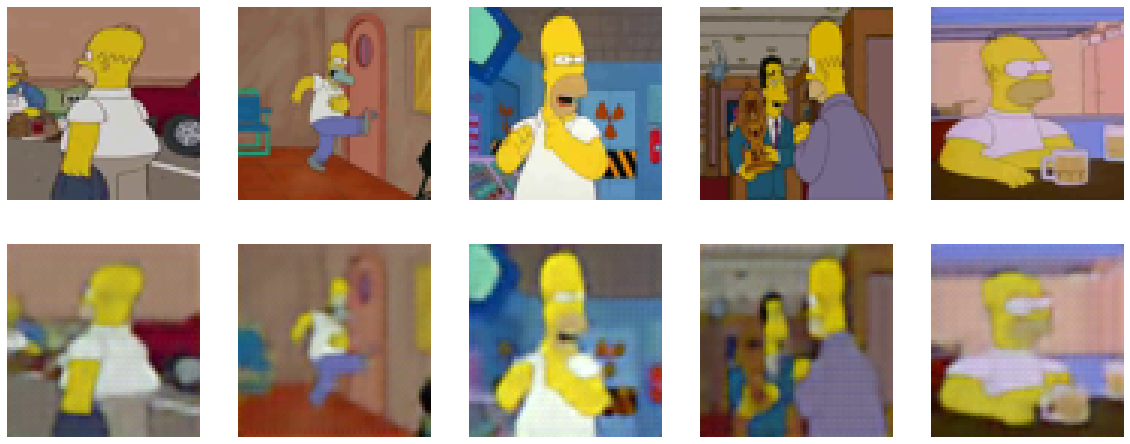

In [ ]:
homer_test_ind = list(np.random.choice(homer_test.shape[0],5))
#homer_test_ind = [0, 1, 2, 3, 4]
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 2
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i,ind in enumerate(homer_test_ind):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(homer_test[ind])

for i,ind in enumerate(homer_test_ind):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 6)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(test_out2[ind])

plt.show()

## Training and evaluation
  * Train the model on the augmented data for 200 epochs without early stopping.
  * Plot the training curve (train/validation loss and mse).
  * Evaluate the trained model on the test set.
  * Plot some (5) reconstruction examples. (Input and prediction pairs.)
  * Calculate the mean and the std of the MAE loss on the validation dataset, then set the classification threshold to the following: `<thrs> = <mean> + 0.5*<std>`
  * Evaluate the classification performance on the test set.
  * And finally evaluate the classification performance on the Flowers dataset.

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

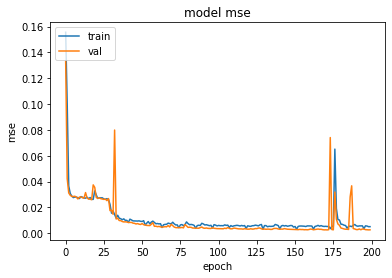

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

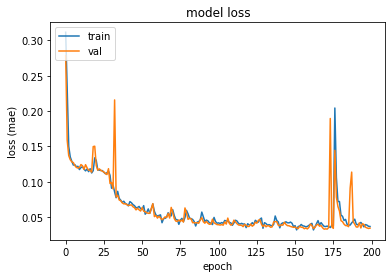

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (mae)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
eval = model.evaluate_generator(homer_val_gen, steps=15, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
15/15 [==============================] - 1s 34ms/step - loss: 0.0345 - mse: 0.0027


In [ ]:
val_pred = model.predict(homer_val/255.)
mae_mean = (abs(val_pred - homer_val/255.)).mean(axis=(1,2,3))
mae_std = (abs(val_pred - homer_val/255.)).std(axis=(1,2,3))
print(mae_mean.mean(),mae_std.mean())

0.03447527034974852 0.03804683182013859


In [ ]:
thresh = mae_mean.mean()+0.5*mae_std.mean()

In [ ]:
homer_test_pred = model.predict(homer_test/255.)
homer_cls = abs(homer_test_pred - homer_test/255.).mean(axis=(1,2,3)) < thresh

In [ ]:
np.unique(homer_cls,return_counts=True)

(array([False,  True]), array([  7, 443]))

In [ ]:
flower_pred = model.predict(flower_array/255.)
flower_cls = abs(flower_pred - flower_pred/255.).mean(axis=(1,2,3)) < thresh
np.unique(flower_cls,return_counts=True)

(array([False,  True]), array([4311,    8]))

In [ ]:
print('True positive: ', round(443/450*100,2), '%')
print('False negative: ', round(7/450*100,2), '%')
print('False posetive: ', round(10/4319*100,2), '%')
print('True negative: ', round(4309/4319*100,2), '%')

True positive:  98.44 %
False negative:  1.56 %
False posetive:  0.23 %
True negative:  99.77 %
